In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pdb
%matplotlib inline


In [33]:
bezirke = [
    'charlottenburg-wilmersdorf',
    'friedrichshain-kreuzberg',
    'lichtenberg',
    'marzahn-hellersdorf',
    'mitte',
    'neukoelln',
    'pankow',
    'reinickendorf',
    'spandau',
    'steglitz-zehlendorf',
    'tempelhof-schoeneberg',
    'treptow-koepenick'
]
years = [2012, 2013, 2014, 2015, 2016]
data_path = '../data/raw/'

dfs = []
for year in years:
    for bezirk in bezirke:
        df = pd.read_csv( data_path + str(year) +'-'+ bezirk + '.csv', sep=';')
        df = df.dropna()
        df = df.assign(bezirk=bezirk, year=year)
        total_number_names = df['anzahl'].sum()
        df = df.assign(frequency = lambda df: df['anzahl']/total_number_names )
        #df_m = df[df['geschlecht']=='m']
        #print(df_m[ df_m['frequency'] == df_m['frequency'].max() ]['vorname'])
        dfs.append(df)
        
df = pd.concat(dfs)
#df = df.sort_values('anzahl', ascending=False )

In [34]:
df.head()

,anzahl,bezirk,frequency,geschlecht,vorname,year
0,122,charlottenburg-wilmersdorf,0.013676,w,Marie,2012
1,105,charlottenburg-wilmersdorf,0.011770,w,Sophie,2012
2,78,charlottenburg-wilmersdorf,0.008743,w,Charlotte,2012
3,69,charlottenburg-wilmersdorf,0.007735,w,Maria,2012
4,66,charlottenburg-wilmersdorf,0.007398,m,Paul,2012


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135989 entries, 0 to 1127
Data columns (total 6 columns):
anzahl        135989 non-null int64
bezirk        135989 non-null object
frequency     135989 non-null float64
geschlecht    135989 non-null object
vorname       135989 non-null object
year          135989 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 7.3+ MB


Most common names:  [('Marie', 'w'), ('Sophie', 'w'), ('Alexander', 'm'), ('Charlotte', 'w'), ('Maria', 'w'), ('Paul', 'm'), ('Maximilian', 'm'), ('Emilia', 'w'), ('Elias', 'm'), ('Emma', 'w')]


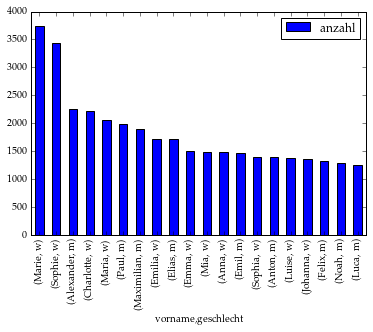

In [36]:
# Group names, calculate most common nampes
dfgroup = df[['year','vorname','anzahl','geschlecht']].groupby(by=['vorname', 'geschlecht']).sum()
dfgroup = dfgroup.sort_values('anzahl', ascending=False)
#dfgroup.assign(name = dfgroup.index)
#plt.bar(dfgroup[0:10].index, dfgroup['anzahl'][0:10])
dfgroup[0:20].plot.bar(y='anzahl')
most_common_names = list(dfgroup[0:300].index)
print('Most common names: ', most_common_names[0:10])
#dfgroup.index
#for vorname in dfgroup['vorname'].unique():
#    nameseries = dfgroup[dfgroup['vorname'] == vorname]
#    plt.plot(nameseries['Year'], nameseries['anzahl'], label=vorname )

In [37]:
# Calculate the mean frequency of the most common names per year
mean_freqs = pd.DataFrame(columns=['vorname', 'year', 'mean_freq', 'geschlecht'])
for name, geschlecht in most_common_names: #df['vorname'].unique():
    for year in df['year'].unique():
        mean_freq = df[ (df['vorname'] == name) & (df['year']==year) & (df['geschlecht']==geschlecht)]['frequency'].mean()
#        mean_freqs.append(pd.DataFrame([name, year, mean_freq]))
        mean_freqs.loc[mean_freqs.shape[0]] = [name, year, mean_freq, geschlecht]

mean_freqs['id'] = mean_freqs['vorname'] + mean_freqs['geschlecht'] + mean_freqs['year'].map(int).map(str)
#mean_freqs['id'].apply(lambda x: str(x['vorname']) + str(x['year']))
mean_freqs.head(10)

,vorname,year,mean_freq,geschlecht,id
0,Marie,2012.0,0.012783,w,Mariew2012
1,Marie,2013.0,0.011896,w,Mariew2013
2,Marie,2014.0,0.011554,w,Mariew2014
3,Marie,2015.0,0.012445,w,Mariew2015
4,Marie,2016.0,0.010603,w,Mariew2016
5,Sophie,2012.0,0.012550,w,Sophiew2012
6,Sophie,2013.0,0.011471,w,Sophiew2013
7,Sophie,2014.0,0.011502,w,Sophiew2014
8,Sophie,2015.0,0.010157,w,Sophiew2015
9,Sophie,2016.0,0.009063,w,Sophiew2016


In [38]:
# Add mean_freq to df (RUN ONLY ONCE)
df['id'] = df['vorname'] + df['geschlecht'] + df['year'].map(str)
df = pd.merge(df, mean_freqs[['mean_freq','id']], on='id', how='outer')
df.head()

,anzahl,bezirk,frequency,geschlecht,vorname,year,id,mean_freq
0,122,charlottenburg-wilmersdorf,0.013676,w,Marie,2012,Mariew2012,0.012783
1,66,friedrichshain-kreuzberg,0.010563,w,Marie,2012,Mariew2012,0.012783
2,53,lichtenberg,0.011822,w,Marie,2012,Mariew2012,0.012783
3,21,marzahn-hellersdorf,0.012696,w,Marie,2012,Mariew2012,0.012783
4,83,mitte,0.010241,w,Marie,2012,Mariew2012,0.012783


## Trends

In [39]:
df_trend = df[ (df['year']==2012) | (df['year']==2016)]
df_trend[df_trend['year']==2016].head(50)
df_trend['idbezirk'] = df_trend['vorname'] + ' ' + df_trend['geschlecht'] + ' '+ df_trend['bezirk']
df_trend = df_trend.pivot(index='idbezirk',columns='year', values='anzahl')
df_trend = df_trend.fillna(0)
#df_trend.assign(trend = lambda x: (x[2016]-x[2012])/x[2012] if (x[2012] != 0) else inf  )
df_trend = df_trend[df_trend[2012]!=0.0]
df_trend = df_trend.assign(trend = lambda x: (x[2016]-x[2012])/x[2012] )
df_trend = df_trend.sort_values('trend', ascending=True)
df_trend.head(5)
#df['freq_2012'] = df['frequency']
#df['freq_2016'] = df['frequency']
#df.groupby(by=[])

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


year,2012,2016,trend
idbezirk,,,
(Eigenname) m reinickendorf,1.0,0.0,-1.0
Maj w tempelhof-schoeneberg,1.0,0.0,-1.0
Maj w friedrichshain-kreuzberg,1.0,0.0,-1.0
Maitreya w friedrichshain-kreuzberg,1.0,0.0,-1.0
Maita w spandau,1.0,0.0,-1.0


In [40]:
#df_trend['vorname'], df_trend['geschlecht'], df_trend['bezirk'] = pd.Series(df_trend.index).str.split(' ',2,expand=True)
split_index = pd.Series(df_trend.index, index=df_trend.index).str.split(' ',2, expand=True)
split_index = split_index.rename(columns={0:'vorname', 1:'geschlecht', 2:'bezirk'})
df_trend = pd.concat([df_trend, split_index], axis=1, join_axes=[df_trend.index])

In [41]:
print("Trendigste Namen im Bezirk")
df_trend[(df_trend['bezirk'] == 'mitte')&(df_trend[2016]>10)].head(20)

Trendigste Namen im Bezirk


year,2012,2016,trend,vorname,geschlecht,bezirk
idbezirk,,,,,,
Adrian m mitte,24.0,11.0,-0.541667,Adrian,m,mitte
Helene w mitte,32.0,15.0,-0.531250,Helene,w,mitte
Lukas m mitte,24.0,13.0,-0.458333,Lukas,m,mitte
Emma w mitte,25.0,14.0,-0.440000,Emma,w,mitte
Victoria w mitte,22.0,14.0,-0.363636,Victoria,w,mitte
Jonas m mitte,31.0,21.0,-0.322581,Jonas,m,mitte
David m mitte,32.0,22.0,-0.312500,David,m,mitte
Mia w mitte,27.0,19.0,-0.296296,Mia,w,mitte
Johannes m mitte,22.0,16.0,-0.272727,Johannes,m,mitte


In [42]:
test = pd.Series(df_trend.index, index=df_trend.index).str.split(' ',2, expand=True)
#test.index = df_trend.index
test.head()

,0,1,2
idbezirk,,,
(Eigenname) m reinickendorf,(Eigenname),m,reinickendorf
Maj w tempelhof-schoeneberg,Maj,w,tempelhof-schoeneberg
Maj w friedrichshain-kreuzberg,Maj,w,friedrichshain-kreuzberg
Maitreya w friedrichshain-kreuzberg,Maitreya,w,friedrichshain-kreuzberg
Maita w spandau,Maita,w,spandau


### Ungewöhnlich häufige Vornamen

In [43]:
df['freq_dev'] = (df['frequency'] - df['mean_freq']) / df['mean_freq']
df_freq = df.sort_values('freq_dev', ascending=False)
df_freq[(df_freq['bezirk']=='reinickendorf') & (df_freq['year']==2016) & (df_freq['frequency']>0.0)].dropna().head()

,anzahl,bezirk,frequency,geschlecht,vorname,year,id,mean_freq,freq_dev
112287,5,reinickendorf,0.002717,m,Dean,2016,Deanm2016,0.000719,2.779655
108110,9,reinickendorf,0.004891,w,Maja,2016,Majaw2016,0.001627,2.006182
111513,4,reinickendorf,0.002174,m,Jayden,2016,Jaydenm2016,0.000724,2.001119
113213,5,reinickendorf,0.002717,w,Amira,2016,Amiraw2016,0.000918,1.960358
111634,7,reinickendorf,0.003804,m,Lennard,2016,Lennardm2016,0.001306,1.913295


In [65]:
# Extract top 5 for each bezirk and save to csv
#save_df.append(df_freq)
for year in [2012, 2016]:
    save_df = pd.DataFrame(data=None, columns=df_freq.columns)
    for bezirk in bezirke:
        for geschlecht in ['m', 'w']:
            save_df = save_df.append(
                df_freq[(df_freq['bezirk']==bezirk) & (df_freq['geschlecht']==geschlecht) & (df_freq['year']==year) & (df_freq['frequency']>0.0)].dropna().sort_values('freq_dev', ascending=False).head(7)
            )
    save_df['freq_dev'] = save_df['freq_dev'].apply(lambda x: int(x*100)) 
    save_df['bezirk'] = save_df['bezirk'].apply(lambda x: x.replace('oe','ö').title())
    save_df = save_df[['bezirk', 'geschlecht', 'vorname', 'anzahl', 'freq_dev']]
    save_df.to_csv('../data/processed/beliebte_namen_'+str(year)+'.csv', sep=',', index=False)

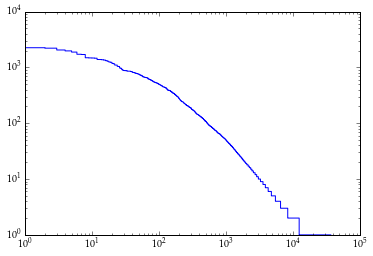

In [45]:
plt.step(x=range(len(dfgroup)),y=dfgroup[ dfgroup['anzahl']>0]['anzahl'])
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

In [46]:
dfgroup2 = df[['Year', 'vorname', 'anzahl']].groupby(by=['vorname', 'Year']).sum()
#dfgroup2 = df[['Year', 'vorname', 'anzahl']].groupby(['vorname', 'Year']).sum().groupby('Year')

#dfgroup2.reset_index()
dfgroup2 = dfgroup2.sort_values('anzahl', ascending=False)
best_names = dfgroup2.index.get_level_values('vorname').unique()[0:10]
#years = dfgroup2.index.get_level_values('Year').unique()
#dfgroup2.iloc[ dfgroup2.index['Year']==2015 ]

#dfgroup2.loc['Marie'].sort_index()
for name in best_names:
    #dfgroup2.loc[name].sort_index().plot.line() 
    plt.plot(dfgroup2.loc[name].sort_index(), label=name)
plt.legend(loc='right')
#dfgroup2.iloc[dfgroup2.index.get_level_values('Year') == 2015]

KeyError: "['Year'] not in index"

In [ ]:
dfgroup.head()

In [ ]:
dfgroup = df.groupby(by=['Year', 'Bezirk', 'vorname']).sum()
dfgroup.head(10)